In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.distributions import Categorical
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as vision_F
from torchvision.models import resnet18


import numpy as np

from torch.utils.data import Dataset, DataLoader

from torchvision.models.resnet import BasicBlock, Bottleneck, conv1x1

from torch import Tensor
from typing import Union, Type, List, Optional, Callable

import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_two_subplots(img1, img2):
    fig, axs = plt.subplots(1, 2, figsize=(4, 4))  # 1 row, 2 columns
    axs[0].imshow(img1)
    axs[1].imshow(img2)
    plt.tight_layout()
    plt.show()

In [52]:
cifar10_dataset = torchvision.datasets.CIFAR10('dataset', download=True)


class MyDatset(Dataset):
    def __init__(self, train_dataset, transform):
        self.train_dataset = train_dataset
        
        if transform == True:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([
                    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
                ], p=0.8),
                # transforms.RandomGrayscale(p=0.2),
                transforms.ToTensor(),
                # normalize,
            ])
        else:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomGrayscale(p=0.2),
                transforms.ToTensor(),
                # normalize,
            ])

    def __len__(self,):
        return len(self.train_dataset)
    
    def __getitem__(self, i):
        img = self.train_dataset[i][0]
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2
    
    

class DataLoaderWrapper:
    def __init__(self, dataloder, steps, encoder, decoder):
        self.dataloder = dataloder
        self.steps = steps
        self.encoder = encoder
        self.decoder = decoder
    
    
    def decoder_transform(self, x):
        
        x1, x2 = x
        x1 = x1.to(device)
        x2 = x2.to(device)

        with torch.no_grad():
            _, z1 = self.encoder(x1)
            _, z2 = self.encoder(x2)

            (_, (transform_actions_index, magnitude_actions_index), _) = self.decoder(z1, z2)

            transforms_list_1, transforms_list_2 = get_transforms_list(transform_actions_index, magnitude_actions_index)
            
            print('pipipopo')
            transforms_list_1sss.append(transforms_list_1)
            transforms_list_2sss.append(transforms_list_2)
            
            x1 = x1.cpu()
            x2 = x2.cpu()
            
            new_x1 = apply_transformations(x1, transforms_list_1)
            new_x2 = apply_transformations(x2, transforms_list_2)
                
        return (new_x1, new_x2)
    
    
    def __len__(self):
        if self.steps in ['all', -1]:
            return len(self.dataloder)
        else:
            return self.steps
    
    def __iter__(self):
        
        transform = (self.encoder is not None) and (self.decoder is not None)
        
        iterator = iter(self.dataloder)
        if not self.steps in ['all', -1]:
            for i in range(self.steps):
                try:
                    x = next(iterator)
                except StopIteration:
                    iterator = iter(self.dataloder)
                    x = next(iterator)
                
                if transform:
                    x = self.decoder_transform(x)
                yield x
                
        else: # self.steps in ['all', -1]
            for x in iterator:
                if transform:
                    x = self.decoder_transform(x)
                yield x
        


def get_cifar10_dataloader(num_steps, batch_size, transform=False, encoder=None, decoder=None):
    ppo_transform = (encoder is not None) and (decoder is not None)   
    
    assert ~transform and ~ppo_transform, 'cant use both random_transform and ppo_transform'
    
    
    dataset = MyDatset(cifar10_dataset, transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    wrapped_data_loader = DataLoaderWrapper(data_loader, num_steps, encoder=encoder, decoder=decoder)

    return wrapped_data_loader

Files already downloaded and verified


# PPO utils:

In [53]:
class DecoderRNN(nn.Module):
    def __init__(
            self,
            embed_size, 
            encoder_dim, 
            decoder_dim,
            num_transforms=4,
            num_discrete_magnitude=11,
            seq_length=10,
            drop_prob=0.3
        ):
        super().__init__()
        
        #save the model param
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

        self.num_transforms = num_transforms
        self.num_discrete_magnitude = num_discrete_magnitude
        self.seq_length = seq_length


        len_action = num_transforms + num_discrete_magnitude + 1 # +1 for the first operation
        self.action_embedding = nn.Embedding(len_action, embed_size)
        self.branch_id_embedding = nn.Embedding(2, embed_size)
        self.action_id_embedding = nn.Embedding(2, embed_size)

        # z + branch_id_embd + prev_action_embd
        self.rnn = nn.LSTMCell(encoder_dim + embed_size + embed_size + embed_size, decoder_dim, bias=True)        
        
        self.fcn_transform = nn.Linear(decoder_dim,num_transforms)
        self.fcn_magnitude = nn.Linear(decoder_dim,num_discrete_magnitude)

    

    def init_hidden_state(self, batch_size):
        h = torch.zeros(batch_size, self.decoder_dim, device=device)
        c = torch.zeros(batch_size, self.decoder_dim, device=device)
        return h, c
    

    def lstm_forward(self, z, branch_id, action_id, prev_action, action_mask, h_t, c_t, decoder):
        """
        z: the representation of the image
        branch_id: 0 or 1, to know which branch are we in (z1 or z2)
        action_id: 0 or 1, to know whather we are selecting a transformation or a magnitude
        prev_action: the index of the previous action taken (transformation and magnitude)
        action_mask: transformation action mask
        h_t: hidden state of the lstm
        c_t: context of the lstmd
        decoder: the decoder (the classifier)
        """
        branch_id_embd   = self.branch_id_embedding(branch_id)
        action_id_embd   = self.action_id_embedding(action_id)
        prev_action_embd = self.action_embedding(prev_action)
        input = torch.concat(
            (z, branch_id_embd, action_id_embd, prev_action_embd),
            dim=-1
        )
        h_t, c_t = self.rnn(input, (h_t, c_t))
        logits = decoder(h_t)
        # print('before:', logits[0])
        if action_mask is not None:
            inf_tensor = torch.full_like(logits, -float('inf'))
            logits = torch.where(action_mask, logits, inf_tensor)
        # print('after :', logits[0])
        # print('-----')
        return h_t, c_t, logits


    def forward(self, z1, z2, old_action_index=None):
        """
        returns:
            transform_actions_index: (batch_size, 2, seq_length)
            magnitude_actions_index: (batch_size, 2, seq_length)
            transform_log_p: (batch_size, 2, seq_length)
            magnitude_log_p: (batch_size, 2, seq_length)
        """
        if old_action_index is not None:
            (old_transform_actions_index, old_magnitude_actions_index) = old_action_index

        #get the seq length to iterate
        seq_length = self.seq_length
        batch_size = z1.size(0)
        
        transform_log_p =  torch.zeros(batch_size, 2, seq_length).to(device)
        transform_actions_index =  torch.zeros(batch_size, 2, seq_length, dtype=torch.long).to(device)

        magnitude_log_p =  torch.zeros(batch_size, 2, seq_length).to(device)
        magnitude_actions_index =  torch.zeros(batch_size, 2, seq_length, dtype=torch.long).to(device)

        branch_id = torch.full((batch_size,2), 0, dtype=torch.long, device=device)
        branch_id[:, 1] = 1
        
        action_id = torch.full((batch_size,2), 0, dtype=torch.long, device=device)
        action_id[:, 1] = 1
        
        features = [z1, z2]
        action_index = torch.LongTensor([self.num_transforms + self.num_discrete_magnitude]).to(device)
        action_index = action_index.repeat(batch_size)

        transform_entropy = 0
        magnitude_entropy = 0
        
        # Initialize LSTM state
        h_t, c_t = self.init_hidden_state(batch_size)  # (batch_size, decoder_dim)
        
        for branch in range(2):

            z = features[branch]
            action_mask = torch.ones((batch_size, self.num_transforms), dtype=torch.bool, requires_grad=False).to(device)

            for step in range(seq_length):
                
                
                
                h_t, c_t, transform_logits = self.lstm_forward(
                    z=z,
                    branch_id=branch_id[:, branch],
                    action_id=action_id[:, 0],
                    prev_action=action_index,
                    action_mask=action_mask,
                    h_t=h_t,
                    c_t=c_t,
                    decoder=self.fcn_transform
                )
                if old_action_index is None:
                    action_index = Categorical(logits=transform_logits).sample()
                else:
                    action_index = old_transform_actions_index[:, branch, step]
                                
                action_mask = action_mask.clone()
                action_mask[range(batch_size), action_index] = 0
                
                log_p = F.log_softmax(transform_logits, dim=-1).gather(-1,action_index.unsqueeze(-1))
                transform_log_p[:, branch, step] = log_p.squeeze(-1)
                transform_actions_index[:, branch, step] = action_index
                transform_entropy += Categorical(logits=transform_logits).entropy().mean()



                h_t, c_t, magnitude_logits = self.lstm_forward(
                    z=z,
                    branch_id=branch_id[:, branch],
                    action_id=action_id[:, 1],
                    prev_action=action_index,
                    action_mask=None,
                    h_t=h_t,
                    c_t=c_t,
                    decoder=self.fcn_magnitude
                )
                if old_action_index is None:
                    action_index = Categorical(logits=magnitude_logits).sample()
                else:
                    action_index = old_magnitude_actions_index[:, branch, step]
                
                log_p = F.log_softmax(magnitude_logits, dim=-1).gather(-1,action_index.unsqueeze(-1))
                magnitude_log_p[:, branch, step] = log_p.squeeze(-1)
                magnitude_actions_index[:, branch, step] = action_index
                magnitude_entropy += Categorical(logits=magnitude_logits).entropy().mean()


        transform_entropy /= (2*seq_length)
        magnitude_entropy /= (2*seq_length)
        
        log_p = transform_log_p.reshape(batch_size, -1).sum(-1) + magnitude_log_p.reshape(batch_size, -1).sum(-1)
        log_p = log_p.unsqueeze(-1)
    
        return (
                log_p,
                (transform_actions_index, magnitude_actions_index),
                (transform_entropy, magnitude_entropy)
            )

In [54]:
class SimCLR(nn.Module):
    def __init__(self, projection_dim=128):
        super(SimCLR, self).__init__()
        self.enc = resnet18(weights=None)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection
    
    
def build_resnet18():
    return SimCLR()

In [55]:
# encoder = build_resnet18()
# # encoder.load_state_dict(torch.load('params/resnet18_contrastive_only_colorjitter.pt'))

# decoder = DecoderRNN(
#     embed_size=8,
#     encoder_dim=128,
#     decoder_dim=512,
#     num_transforms=4,
#     num_discrete_magnitude=10,
#     seq_length=4
# )

# img1, img2 = next(iter(get_cifar10_dataloader(10, 16, True)))
# img1 = img1
# _, z = encoder(img1)

# # Inference:
# transform_preds, magnitude_preds, entropies = decoder(z, z)
# transform_actions_index, transform_log_p = transform_preds
# magnitude_actions_index, magnitude_log_p = magnitude_preds

# # Get the proba:
# new_transform_preds, new_magnitude_preds, new_entropies = decoder(z, z, old_action_index=(transform_actions_index, magnitude_actions_index))
# new_transform_actions_index, new_transform_log_p = new_transform_preds
# new_magnitude_actions_index, new_magnitude_log_p = new_magnitude_preds

# (transform_log_p == new_transform_log_p).all(), (magnitude_log_p == new_magnitude_log_p).all()

In [56]:
TRANSFORMS_DICT = [
    ('brightness', vision_F.adjust_brightness, (0.6, 1.4)),
    ('contrast', vision_F.adjust_contrast, (0.6, 1.4)),
    ('saturation', vision_F.adjust_saturation, (0.6, 1.4)),
    ('hue', vision_F.adjust_hue, (-0.1, 0.1)),
]

def get_transforms_list(actions_transform, actions_magnitude):

    all_transform_lists = []
    for branch in range(actions_transform.size(1)):
        branch_transform_lists = []
        
        for i in range(actions_transform.size(0)):
            transform_list = []

            for s in range(actions_transform.size(2)):
                transform_id = actions_transform[i, branch, s].item()
                magnitude_id = actions_magnitude[i, branch, s].item()
                func_name, func, (lower, upper) = TRANSFORMS_DICT[transform_id]
                step = (upper - lower) / 10
                magnitude = np.arange(start=lower, stop=upper+step, step=step)[magnitude_id]
                transform_list.append((func_name, func, round(magnitude, 5)))
            branch_transform_lists.append(transform_list)
    
        all_transform_lists.append(branch_transform_lists)
        
    return all_transform_lists[0], all_transform_lists[1]


def apply_transformations(img1, transform_list):

    num_samples = img1.size(0)
    stored_imgs = torch.zeros((num_samples, 3, 32, 32))

    for i in range(img1.size(0)):
        img = img1[i]
        for (transform_name, transform_func, magnitude) in transform_list[i]:
            img = transform_func(img, magnitude)
        stored_imgs[i] = img

    return stored_imgs


In [57]:
def multi_dimensional_multinomial(x):
    *leading_axes, last_ax = x.shape
    x = x.reshape((-1, last_ax))
    actions = torch.multinomial(x, 1)
    actions = actions.reshape(leading_axes)
    return actions


def collect_trajectories(len_trajectory, encoder, decoder, batch_size):

    assert len_trajectory % batch_size == 0

    data_loader = get_cifar10_dataloader(
        num_steps=len_trajectory // batch_size,
        batch_size=batch_size,
        transform=False
    )

    encoder_dim = encoder.projector[2].out_features


    stored_z1 = torch.zeros((len_trajectory, encoder_dim))
    stored_z2 = torch.zeros((len_trajectory, encoder_dim))
    # stored_transform_log_p = torch.zeros((len_trajectory, 2, decoder.seq_length))
    # stored_magnitude_log_p = torch.zeros((len_trajectory, 2, decoder.seq_length))
    stored_log_p = torch.zeros((len_trajectory, 1))
    stored_transform_actions_index  = torch.zeros((len_trajectory, 2, decoder.seq_length), dtype=torch.long)
    stored_magnitude_actions_index  = torch.zeros((len_trajectory, 2, decoder.seq_length), dtype=torch.long)
    stored_rewards = torch.zeros((len_trajectory,))

    data_loader_iterator = iter(data_loader)
    for i in range(len_trajectory // batch_size):
#     for i in tqdm(range(len_trajectory // batch_size), desc='collect_trajectories'):

        begin, end = i*batch_size, (i+1)*batch_size

        img1, img2 = next(data_loader_iterator)

        img1 = img1.to(device)
        img2 = img2.to(device)

        with torch.no_grad():
            _, z1 = encoder(img1)
            _, z2 = encoder(img2)

        with torch.no_grad():
            log_p, actions_index, entropies = decoder(z1, z2)
            transform_actions_index, magnitude_actions_index = actions_index


        transforms_list_1, transforms_list_2 = get_transforms_list(transform_actions_index, magnitude_actions_index)
        new_img1 = apply_transformations(img1, transforms_list_1)
        new_img2 = apply_transformations(img2, transforms_list_2)

        new_img1 = new_img1.to(device)
        new_img2 = new_img2.to(device)
        with torch.no_grad():
            _, new_z1 = encoder(new_img1)
            _, new_z2 = encoder(new_img2)
        new_img1 = new_img1.to('cpu')
        new_img2 = new_img2.to('cpu')



        stored_z1[begin:end] = z1.detach().cpu()
        stored_z2[begin:end] = z1.detach().cpu()
        # stored_transform_log_p[begin:end] = transform_log_p.detach().cpu()
        # stored_magnitude_log_p[begin:end] = magnitude_log_p.detach().cpu()
        stored_log_p[begin:end] = log_p.detach().cpu()
        stored_transform_actions_index[begin:end]  = transform_actions_index.detach().cpu()
        stored_magnitude_actions_index[begin:end]  = magnitude_actions_index.detach().cpu()
        # stored_rewards[begin:end] = (new_img1 - new_img2).reshape(batch_size, -1).mean(axis=1)
        stored_rewards[begin:end] = - (F.normalize(new_z1) * F.normalize(new_z2)).sum(axis=-1)


    return (
            (stored_z1, stored_z2), 
            (stored_log_p),
            (stored_transform_actions_index, stored_magnitude_actions_index),
            stored_rewards
        ), (img1, img2, new_img1, new_img2)

# trajectory = collect_trajectories(1024, encoder, decoder, 1024)

In [58]:
def shuffle_trajectory(trajectory):

    (
        (stored_z1, stored_z2), 
        (stored_log_p),
        (stored_transform_actions_index, stored_magnitude_actions_index),
        stored_rewards
    ) = trajectory

    permutation = torch.randperm(stored_z1.size()[0])

    permuted_stored_z1 = stored_z1[permutation]
    permuted_stored_z2 = stored_z2[permutation]
    permuted_stored_log_p = stored_log_p[permutation]
    permuted_stored_transform_actions_index  = stored_transform_actions_index[permutation]
    permuted_stored_magnitude_actions_index  = stored_magnitude_actions_index[permutation]
    permuted_stored_rewards = stored_rewards[permutation]

    permuted_trajectory = (
        (permuted_stored_z1, permuted_stored_z2),
        (permuted_stored_log_p),
        (permuted_stored_transform_actions_index, permuted_stored_magnitude_actions_index),
        permuted_stored_rewards
    )

    return permuted_trajectory

In [67]:
def calculate_entropy(probabilities):
    epsilon = 1e-12
    log_probabilities = torch.log(probabilities + epsilon)
    entropy = -torch.sum(probabilities * log_probabilities, dim=-1)
    return entropy

def ppo_update(trajectory, decoder, optimizer, ppo_batch_size=256, ppo_epochs=4):


    for _ in range(ppo_epochs):
    
        shuffled_trajectory = shuffle_trajectory(trajectory)

        (
            (stored_z1, stored_z2), 
            (permuted_stored_log_p),
            (stored_transform_actions_index, stored_magnitude_actions_index),
            stored_rewards
        ) = shuffled_trajectory

        len_trajectory = stored_z1.shape[0]


        assert len_trajectory % ppo_batch_size == 0

        acc_loss = 0
        acc_loss_counter = 0
        for i in range(len_trajectory // ppo_batch_size):
#         for i in tqdm(range(len_trajectory // ppo_batch_size), desc='ppo_update'):

            begin, end = i*ppo_batch_size, (i+1)*ppo_batch_size

            z1 = stored_z1[begin:end].to(device).detach()
            z2 = stored_z2[begin:end].to(device).detach()
            old_log_p = permuted_stored_log_p[begin:end].to(device).detach()
            transform_actions_index = stored_transform_actions_index[begin:end].to(device).detach()
            magnitude_actions_index = stored_magnitude_actions_index[begin:end].to(device).detach()
            reward = stored_rewards[begin:end].to(device).detach()

            new_log_p, new_actions_index, entropies = decoder(z1, z2, old_action_index=(transform_actions_index, magnitude_actions_index))
            new_transform_actions_index, new_magnitude_actions_index = new_actions_index
            
            assert (transform_actions_index == new_transform_actions_index).all()
            assert (magnitude_actions_index == new_magnitude_actions_index).all()
            
            reward, new_log_p, old_log_p = reward.reshape(-1), new_log_p.reshape(-1), old_log_p.reshape(-1)

        
            advantage = reward
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
            ratio = torch.exp(new_log_p - old_log_p.detach())

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            actor_loss = - torch.min(surr1, surr2).mean()

            loss = actor_loss

            # print('old_log_p', old_log_p.shape)
            # print('advantage', advantage.shape)
            # print('ratio', ratio.shape)
            # print('torch.min(surr1, surr2)', torch.min(surr1, surr2).shape)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc_loss += loss.item()
            acc_loss_counter += 1

    return acc_loss / acc_loss_counter
    

---
# Contrastive utils:

In [68]:
class InfoNCELoss(nn.Module):
    def __init__(self):
        super(InfoNCELoss, self).__init__()
        self.CE = nn.CrossEntropyLoss()


    def forward(self, z1, z2, batch_size, temperature):
        features = torch.cat((z1, z2), dim=0)

        labels = torch.cat([torch.arange(batch_size) for i in range(2)], dim=0).to(device)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

        features = F.normalize(features, dim=1)

        full_similarity_matrix = torch.matmul(features, features.T)

        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = full_similarity_matrix[~mask].view(full_similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

        logits = logits / temperature
        loss = self.CE(logits, labels)

        return full_similarity_matrix, logits, loss
    
# criterion = InfoNCELoss()

In [69]:
def top_k_accuracy(sim, k):
    n_samples = sim.shape[0] // 2
    sim[range(sim.shape[0]), range(sim.shape[0])] = -1
    y_index = torch.tensor(list(range(n_samples, sim.shape[0]))).reshape(-1, 1)
    acc = (sim.argsort()[:n_samples, -k:].detach().cpu() == y_index).any(-1).sum() / n_samples
    return acc.item()

---
# Training:

In [70]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [71]:
def ppo_init():

    # encoder = build_resnet18()
    # encoder.load_state_dict(torch.load('params/resnet18_contrastive_only_colorjitter.pt'))
    # encoder = encoder.to(device)

    decoder = DecoderRNN(
        embed_size=1024,
        encoder_dim=128,
        decoder_dim=512,
        num_transforms=4,
        num_discrete_magnitude=10,
        seq_length=4
    ).to(device)
    
    decoder.load_state_dict(torch.load('params_/decoder (1).pt'))

    optimizer = torch.optim.Adam(
        decoder.parameters(),
        lr=0.001
    )

    list(decoder.parameters())[-1]

    return decoder, optimizer


def contrastive_init():
    
    encoder = build_resnet18()
#     encoder.load_state_dict(torch.load('/kaggle/input/resnet18_contrastive.pt'))
    encoder = encoder.to(device)

    criterion = InfoNCELoss()

    optimizer = torch.optim.SGD(
        encoder.parameters(),
        lr=0.01,
        momentum=0.9,
        weight_decay=1e-6,
        nesterov=True)


    def get_lr(step, total_steps, lr_max, lr_min):
        return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(step / total_steps * np.pi))

    scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
            step,
            100 * 50000 // 512,
            0.6,  # lr_lambda computes multiplicative factor
            1e-3
        )
    )
    
    return encoder, optimizer, scheduler, criterion


def init():
    
    encoder, simclr_optimizer, simclr_scheduler, simclr_criterion = contrastive_init()
    decoder, ppo_optimizer = ppo_init()
    
    return (
        (encoder, simclr_optimizer, simclr_scheduler, simclr_criterion),
        (decoder, ppo_optimizer) 
    )

In [72]:
def ppo_round(encoder, decoder, optimizer, ppo_rounds, len_trajectory, batch_size, ppo_epochs, ppo_batch_size):
    
    losses = []
    rewards = []
    
    tqdm_range = tqdm(range(ppo_rounds))
    for round_ in tqdm_range:
    
        trajectory, (img1, img2, new_img1, new_img2) = collect_trajectories(
            len_trajectory=len_trajectory,
            encoder=encoder,
            decoder=decoder,
            batch_size=batch_size
        )

        loss = ppo_update(
            trajectory,
            decoder,
            optimizer,
            ppo_epochs=ppo_epochs,
            ppo_batch_size=ppo_batch_size,
        )
        
        losses.append(loss)
        rewards.append(float(trajectory[-1].mean()))
        
        tqdm_range.set_description(f'[ppo_round] Reward: {rewards[-1]:.4f}')
        
    
    return trajectory, (img1, img2, new_img1, new_img2), (losses, rewards)

In [73]:

def contrastive_round(model, num_steps, batch_size, optimizer, scheduler, criterion, ppo_transform, encoder, decoder, PLOT_EACH=10):
    
    losses = []
    top_1_score = []
    top_5_score = []
    top_10_score = []
    
    if ppo_transform:
        train_loader = get_cifar10_dataloader(
            num_steps=num_steps, 
            batch_size=batch_size, 
            transform=False, 
            encoder=encoder, 
            decoder=decoder
        )
    else:
        train_loader = get_cifar10_dataloader(
            num_steps=num_steps,
            batch_size=batch_size,
            transform=True
        )

    
    tqdm_train_loader = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (x1, x2) in tqdm_train_loader:
        
        # plot_two_subplots(x1[0].permute(1,2,0), x2[1].permute(1,2,0))
        # break
        # print(x1.requires_grad)
        
        x1 = x1.to(device)
        x2 = x2.to(device)

        _, z1 = model(x1)
        _, z2 = model(x2)

        # print(z1)
        # break
        
        sim, _, loss = criterion(z1, z2, batch_size=x1.shape[0], temperature=0.07)
        
        # print(i, loss)
        # plt.imshow(sim[:256, 256:].detach().cpu())
        # plt.show()
        
        
        # break

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        scheduler.step()

        losses.append( loss.item() )
        top_1_score.append( top_k_accuracy(sim, 1) )
        top_5_score.append( top_k_accuracy(sim, 5) )
        top_10_score.append( top_k_accuracy(sim, 10) )

        tqdm_train_loader.set_description(f'[contrastive_round] Loss: {loss.item():.4f}')


        del x1, x2, loss, _
        torch.cuda.empty_cache()

#         if i % PLOT_EACH == 0:
#             clear_output(True)

#             sim, _, _ = criterion(z1, z2, batch_size=z1.shape[0], temperature=0.07)

#             fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
#             ax1.imshow(sim.cpu().detach(), vmin=-1, vmax=1, cmap='hot')
#             ax2.plot(smooth_curve(losses))
#             ax3.plot(smooth_curve(top_1_score))
#             ax3.plot(smooth_curve(top_5_score))
#             ax3.plot(smooth_curve(top_10_score))

#             plt.show()
#         break
        
    return (sim.cpu().detach(), losses, top_1_score, top_5_score, top_10_score)

In [74]:
(
    (encoder, simclr_optimizer, simclr_scheduler, simclr_criterion),
    (decoder, ppo_optimizer) 
) = init()

ppo_rewards_metric = []
crst_losses = []
crst_top_1_score = []
crst_top_5_score = []
crst_top_10_score = []

for step in range(10):
    
    print(f'Training step {step} '+'-'*150)
    
    # print(list(encoder.projector[2].parameters())[0])
    
    # (sim, losses, top_1_score, top_5_score, top_10_score) = contrastive_round(
    #     encoder, 
    #     num_steps=50, 
    #     batch_size=512, 
    #     optimizer=simclr_optimizer, 
    #     scheduler=simclr_scheduler, 
    #     criterion=simclr_criterion, 
    #     encoder=encoder,
    #     decoder=decoder,
    #     ppo_transform=False if step == 0 else True
    #     # ppo_transform=False
    # )    
    # crst_losses += losses
    # crst_top_1_score += top_1_score
    # crst_top_5_score += top_5_score
    # crst_top_10_score += top_10_score
    
    # clear_output(True)
    # print(f'Training step {step} '+'-'*150)
    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    # ax1.imshow(sim.cpu().detach(), vmin=-1, vmax=1, cmap='hot')
    # ax2.plot(smooth_curve(crst_losses))
    # ax3.plot(smooth_curve(crst_top_5_score))
    # ax4.plot(smooth_curve(ppo_rewards_metric))
    # plt.show()
    
    
    trajectory, (img1, img2, new_img1, new_img2), (ppo_losses, ppo_rewards) = ppo_round(
        encoder, 
        decoder,
        ppo_optimizer,
        ppo_rounds=50,
        len_trajectory=512*4, 
        batch_size=512*2, 
        ppo_epochs=4, 
        ppo_batch_size=256
    )
    
    # print(list(encoder.projector[2].parameters())[0])
    
    
    ppo_rewards_metric += ppo_rewards
    
    # clear_output(True)
    # print(f'Training step {step} '+'-'*150)
    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    # ax1.imshow(sim.cpu().detach(), vmin=-1, vmax=1, cmap='hot')
    # ax2.plot(smooth_curve(crst_losses))
    # ax3.plot(smooth_curve(crst_top_5_score))
    # ax4.plot(smooth_curve(ppo_rewards_metric))
    # plt.show()
    
    break

Training step 0 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([256])
advantage torch.Size([256])
ratio torch.Size([256])
torch.min(surr1, surr2) torch.Size([256])
old_log_p torch.Size([25

[ppo_round] Reward: -0.9149:   2%|▏         | 1/50 [00:07<06:25,  7.87s/it]


KeyboardInterrupt: 

In [ ]:
# for i in range(10):
#     plot_two_subplots(new_img1[i].permute(1,2,0), new_img2[i].permute(1,2,0))

In [ ]:


# for i in range(5):
#     plot_two_subplots(new_img1[i].permute(1,2,0), new_img2[i].permute(1,2,0))

In [ ]:
(
    (encoder, simclr_optimizer, simclr_scheduler, simclr_criterion),
    (decoder, ppo_optimizer) 
) = init()

# decoder.load_state_dict(torch.load('params/nyuad_decoder.pt',  map_location=device))

train_loader = get_cifar10_dataloader(
    num_steps=1000, 
    batch_size=10, 
    transform=False, 
    encoder=encoder, 
    decoder=decoder
)

In [ ]:
for trans1, trans2 in zip(transforms_list_1sss[0], transforms_list_2sss[0]):
    [ print(t1, m1, '|', t2, m2) for ((t1, _, m1), (t2, _, m2)) in zip(trans1, trans2)  ]
    print('-----')

hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue -0.1 | saturation 1.32
saturation 0.6 | hue 0.08
contrast 1.32 | brightness 0.6
brightness 1.32 | contrast 0.6
-----
hue 0.08 | brightness 1.32
satur

pipipopo


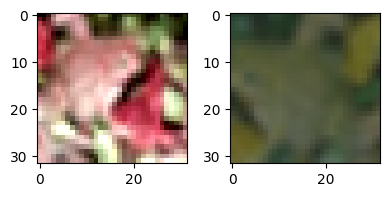

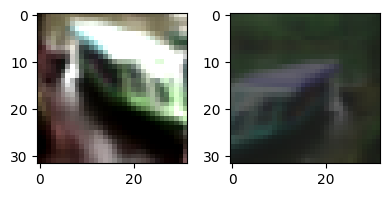

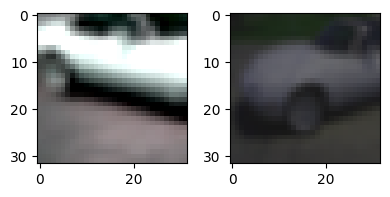

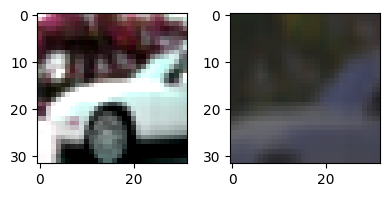

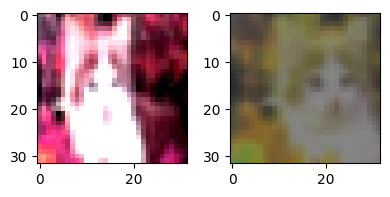

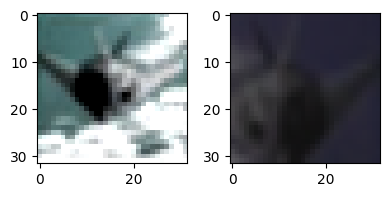

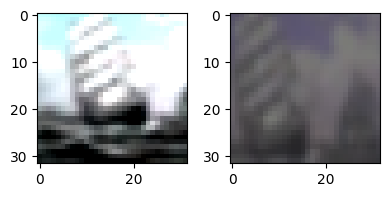

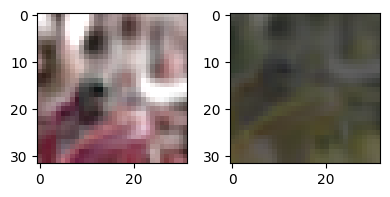

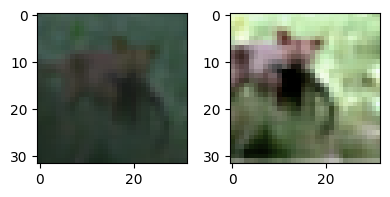

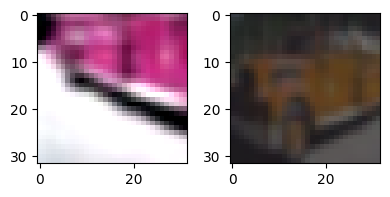

In [ ]:
transforms_list_1sss = []
transforms_list_2sss = []

for img1, img2 in train_loader:
    for i in range(img1.shape[0]):
        plot_two_subplots(img1[i].permute(1,2,0), img2[i].permute(1,2,0))
    break